In [56]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import pandas as pd
from pandas import DataFrame as dframe
import cvxpy as cv

In [57]:
def Dic(feat_l_tr,feat_r_tr): #入力の配列は2次元配列である必要がある
    feat_tr = np.concatenate([feat_l_tr, feat_r_tr],0)
    return feat_tr

In [58]:
#各クラスの特徴ベクトルの配列の列数を格納した配列を引数にすればもう少し拡張性が上がる
def SGRM(feat_tr,feat_tr_dic_1,feat_tr_dic_2,feat_tr_dic,feat_l_te,matrix_index):
    λ_1 = 0.05
    λ_2 = 0.05
    answer = np.zeros(feat_l_te.shape[1])
    SGRM_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SGRM_l_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SGRM_r_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    for i in range(feat_l_te.shape[1]):
        u = cv.Variable((feat_tr_dic.shape[1],1)) #目的関数の次元
        objective = cv.Minimize(0.5*(cv.norm(feat_tr_dic@u-feat_l_te[:,i,np.newaxis],2)**2)
                                +λ_1*cv.norm(u[:,0],1)
                                +λ_2*(cv.norm(u[0:feat_tr.shape[0],0],2)
                                      +cv.norm(u[feat_tr.shape[0]:feat_tr_dic_1.shape[0],0],2)
                                     +cv.norm(u[feat_tr_dic_1.shape[0]:feat_tr_dic_2.shape[0],0],2)
                                     +cv.norm(u[feat_tr_dic_2.shape[0]:feat_tr_dic.shape[0],0],2)))
                                     #+cv.norm(u[feat_tr_dic_4.shape[0]:feat_tr_dic_5.shape[0],0],2)
                                     #+cv.norm(u[feat_tr_dic_5.shape[0]:feat_tr_dic_6.shape[0],0],2)
                                     #+cv.norm(u[feat_tr_dic_6.shape[0]:feat_tr_dic.shape[0],0],2)))
        #constraints = [u == 0.5*(cv.norm(feat_tr_dic@u-feat_l_te[:,i,np.newaxis],2)**2)+λ_1*cv.norm(u[:,0],1)
                       #+λ_2*(cv.norm(u[0:feat_tr.shape[0],0],2)
                             #+cv.norm(u[feat_tr.shape[0]:feat_tr_dic_1.shape[0],0],2)
                             #+cv.norm(u[feat_tr_dic_1.shape[0]:feat_tr_dic_2.shape[0],0],2)
                             #+cv.norm(u[feat_tr_dic_2.shape[0]:feat_tr_dic_3.shape[0],0],2)
                             #+cv.norm(u[feat_tr_dic_3.shape[0]:feat_tr_dic.shape[0],0],2))] 
                    
        prob = cv.Problem(objective)
        result = prob.solve()
        #classVariableから値を取るためには.valueを付ける
        SGRM_Cla[:,i] = np.squeeze(u.value)
        #各クラスに関連する表現ベクトルの値を抜き出す
        #lは仕切りの値
        l = 0
        j = 0
        while j < matrix_index.shape[0]-1:
            SGRM_l_Cla[l:l+matrix_index[j],i] = SGRM_Cla[l:l+matrix_index[j],i]     
            l = l + matrix_index[j]
            j = j + 1
            SGRM_r_Cla[l:l+matrix_index[j],i] = SGRM_Cla[l:l+matrix_index[j],i]
            l = l + matrix_index[j]
            j = j + 1
    #パラメータを使って擬似的に各クラスのテスト信号の特徴ベクトルを作成
    dout_feat_l_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))
    dout_feat_r_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) 
    for i in range(feat_l_te.shape[1]):
        dout_feat_l_te[:,i] = feat_tr_dic@SGRM_l_Cla[:,i]
    for i in range(feat_l_te.shape[1]):
        dout_feat_r_te[:,i] = feat_tr_dic@SGRM_r_Cla[:,i]
    #作成した擬似特徴ベクトルとの残差を求める
    R_l =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) #残差を格納するための配列
    R_r =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))  
    for i in range(feat_l_te.shape[1]):
        R_l[:,i] = feat_l_te[:,i]-dout_feat_l_te[:,i]
        R_r[:,i] = feat_l_te[:,i]-dout_feat_r_te[:,i]
        if np.linalg.norm(R_l[:,i], ord=2) < np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 1
        elif np.linalg.norm(R_l[:,i], ord=2) > np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 2
    return answer

In [59]:
def SGRM_test(filename1,filename2,filename3,filename4,C1_K1,C2_K1,C1_K2,C2_K2,C1_K3,C2_K3):
    #対象被験者の特徴ベクトルをMATLABから入手
    feat_C1 = np.loadtxt(filename1,delimiter=",")
    feat_C2 = np.loadtxt(filename2,delimiter=",")
    feat_Test_C1 = np.loadtxt(filename3,delimiter=",")
    feat_Test_C2 = np.loadtxt(filename4,delimiter=",")
    #非対象被験者の特徴ベクトルをMATLABから入手
    feat_C1_K1 = np.loadtxt(C1_K1,delimiter=",")
    feat_C2_K1 = np.loadtxt(C2_K1,delimiter=",")
    feat_C1_K2 = np.loadtxt(C1_K2,delimiter=",")
    feat_C2_K2 = np.loadtxt(C1_K2,delimiter=",")
    feat_C1_K3 = np.loadtxt(C1_K3,delimiter=",")
    feat_C2_K3 = np.loadtxt(C1_K3,delimiter=",")

    #Tは被験者の試行回数である
    feat_tr = Dic(feat_C1,feat_C2)
    #非対象被験者の特徴ベクトルも同様の処理を行う
    feat_tr_K1 = Dic(feat_C1_K1,feat_C2_K1)
    feat_tr_K2 = Dic(feat_C1_K2,feat_C2_K2)
    feat_tr_K3 = Dic(feat_C1_K3,feat_C2_K3)

    #それぞれの特徴ベクトルをつなげる
    feat_tr_dic_1 = Dic(feat_tr,feat_tr_K1)
    feat_tr_dic_2 = Dic(feat_tr_dic_1,feat_tr_K2)
    feat_tr_dic = Dic(feat_tr_dic_2,feat_tr_K3).T
    #feat_tr_dicはすべての特徴ベクトルをつなげたもの
    #まず、分類に用いるテストデータの特徴ベクトルを2次元に変換
    feat_l_te = feat_Test_C1;
    feat_r_te = feat_Test_C2;
    feat_l_te = feat_l_te.T
    feat_r_te = feat_r_te.T

    matrix_index = np.array([feat_C1.shape[0],feat_C2.shape[0],feat_C1_K1.shape[0],feat_C2_K1.shape[0],feat_C1_K2.shape[0],feat_C2_K2.shape[0],
                        feat_C1_K3.shape[0],feat_C2_K3.shape[0]])
    answer1 = SGRM(feat_tr,feat_tr_dic_1,feat_tr_dic_2,feat_tr_dic,feat_l_te,matrix_index)
    answer2 = SGRM(feat_tr,feat_tr_dic_1,feat_tr_dic_2,feat_tr_dic,feat_r_te,matrix_index)
    x1 = 0
    x2 = 0
    for i in range(answer1.shape[0]):
        if answer1[i] == 1:
            x1 = x1 + 1
        if answer2[i] == 2:
            x2 = x2 + 1
        temp1 = ((x1)/(answer1.shape[0]))*100
        temp2 = ((x2)/(answer2.shape[0]))*100
        temp = ((x1+x2)/(answer1.shape[0]+answer2.shape[0]))*100
                    
    return temp,temp1,temp2

In [60]:
#各クラスの特徴ベクトルの配列の列数を格納した配列を引数にすればもう少し拡張性が上がる
def SGRM(feat_tr,feat_tr_dic_1,feat_tr_dic_2,feat_tr_dic,feat_l_te,matrix_index,λ_1,λ_2):
    #λ_1 = 0.01
    #λ_2 = 0.01
    answer = np.zeros(feat_l_te.shape[1])
    SGRM_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SGRM_l_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SGRM_r_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    for i in range(feat_l_te.shape[1]):
        u = cv.Variable((feat_tr_dic.shape[1],1)) #目的関数の次元
        objective = cv.Minimize(0.5*(cv.norm(feat_tr_dic@u-feat_l_te[:,i,np.newaxis],2)**2)
                                +λ_1*cv.norm(u[:,0],1)
                                +λ_2*(cv.norm(u[0:feat_tr.shape[0],0],2)
                                      +cv.norm(u[feat_tr.shape[0]:feat_tr_dic_1.shape[0],0],2)
                                     +cv.norm(u[feat_tr_dic_1.shape[0]:feat_tr_dic_2.shape[0],0],2)
                                     +cv.norm(u[feat_tr_dic_2.shape[0]:feat_tr_dic.shape[0],0],2)))
                                     #+cv.norm(u[feat_tr_dic_3.shape[0]:feat_tr_dic.shape[0],0],2)))
                                     #+cv.norm(u[feat_tr_dic_4.shape[0]:feat_tr_dic_5.shape[0],0],2)
                                     #+cv.norm(u[feat_tr_dic_5.shape[0]:feat_tr_dic_6.shape[0],0],2)
                                     #+cv.norm(u[feat_tr_dic_6.shape[0]:feat_tr_dic.shape[0],0],2)))
        #constraints = [u == 0.5*(cv.norm(feat_tr_dic@u-feat_l_te[:,i,np.newaxis],2)**2)+λ_1*cv.norm(u[:,0],1)
                       #+λ_2*(cv.norm(u[0:feat_tr.shape[0],0],2)
                             #+cv.norm(u[feat_tr.shape[0]:feat_tr_dic_1.shape[0],0],2)
                             #+cv.norm(u[feat_tr_dic_1.shape[0]:feat_tr_dic_2.shape[0],0],2)
                             #+cv.norm(u[feat_tr_dic_2.shape[0]:feat_tr_dic_3.shape[0],0],2)
                             #+cv.norm(u[feat_tr_dic_3.shape[0]:feat_tr_dic.shape[0],0],2))] 
                    
        prob = cv.Problem(objective)
        result = prob.solve()
        #classVariableから値を取るためには.valueを付ける
        SGRM_Cla[:,i] = np.squeeze(u.value)
        #各クラスに関連する表現ベクトルの値を抜き出す
        #lは仕切りの値
        l = 0
        j = 0
        while j < matrix_index.shape[0]-1:
            SGRM_l_Cla[l:l+matrix_index[j],i] = SGRM_Cla[l:l+matrix_index[j],i]     
            l = l + matrix_index[j]
            j = j + 1
            SGRM_r_Cla[l:l+matrix_index[j],i] = SGRM_Cla[l:l+matrix_index[j],i]
            l = l + matrix_index[j]
            j = j + 1
    #パラメータを使って擬似的に各クラスのテスト信号の特徴ベクトルを作成
    dout_feat_l_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))
    dout_feat_r_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) 
    for i in range(feat_l_te.shape[1]):
        dout_feat_l_te[:,i] = feat_tr_dic@SGRM_l_Cla[:,i]
    for i in range(feat_l_te.shape[1]):
        dout_feat_r_te[:,i] = feat_tr_dic@SGRM_r_Cla[:,i]
    #作成した擬似特徴ベクトルとの残差を求める
    R_l =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) #残差を格納するための配列
    R_r =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))  
    for i in range(feat_l_te.shape[1]):
        R_l[:,i] = feat_l_te[:,i]-dout_feat_l_te[:,i]
        R_r[:,i] = feat_l_te[:,i]-dout_feat_r_te[:,i]
        if np.linalg.norm(R_l[:,i], ord=2) < np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 1
        elif np.linalg.norm(R_l[:,i], ord=2) > np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 2
    return answer

In [61]:
def SGRM_test(filename1,filename2,filename3,filename4,C1_K1,C2_K1,C1_K2,C2_K2,C1_K3,C2_K3):
    #対象被験者の特徴ベクトルをMATLABから入手
    feat_C1 = np.loadtxt(filename1,delimiter=",")
    feat_C2 = np.loadtxt(filename2,delimiter=",")
    feat_Test_C1 = np.loadtxt(filename3,delimiter=",")
    feat_Test_C2 = np.loadtxt(filename4,delimiter=",")
    #非対象被験者の特徴ベクトルをMATLABから入手
    feat_C1_K1 = np.loadtxt(C1_K1,delimiter=",")
    feat_C2_K1 = np.loadtxt(C2_K1,delimiter=",")
    feat_C1_K2 = np.loadtxt(C1_K2,delimiter=",")
    feat_C2_K2 = np.loadtxt(C1_K2,delimiter=",")
    feat_C1_K3 = np.loadtxt(C1_K3,delimiter=",")
    feat_C2_K3 = np.loadtxt(C1_K3,delimiter=",")

    #Tは被験者の試行回数である
    feat_tr = Dic(feat_C1,feat_C2)
    #非対象被験者の特徴ベクトルも同様の処理を行う
    feat_tr_K1 = Dic(feat_C1_K1,feat_C2_K1)
    feat_tr_K2 = Dic(feat_C1_K2,feat_C2_K2)
    feat_tr_K3 = Dic(feat_C1_K3,feat_C2_K3)

    #それぞれの特徴ベクトルをつなげる
    feat_tr_dic_1 = Dic(feat_tr,feat_tr_K1)
    feat_tr_dic_2 = Dic(feat_tr_dic_1,feat_tr_K2)
    feat_tr_dic = Dic(feat_tr_dic_2,feat_tr_K3).T
    #feat_tr_dicはすべての特徴ベクトルをつなげたもの
    #まず、分類に用いるテストデータの特徴ベクトルを2次元に変換
    feat_l_te = feat_Test_C1;
    feat_r_te = feat_Test_C2;
    feat_l_te = feat_l_te.T
    feat_r_te = feat_r_te.T

    matrix_index = np.array([feat_C1.shape[0],feat_C2.shape[0],feat_C1_K1.shape[0],feat_C2_K1.shape[0],feat_C1_K2.shape[0],feat_C2_K2.shape[0],
                        feat_C1_K3.shape[0],feat_C2_K3.shape[0]])
    Max = 0
    for i in range(1,5):
        λ_1 = i*0.01
        print(i)
        for j in range(1,7):
            λ_2 = j*0.01
            answer1 = SGRM(feat_tr,feat_tr_dic_1,feat_tr_dic_2,feat_tr_dic,feat_l_te,matrix_index,λ_1,λ_2)
            answer2 = SGRM(feat_tr,feat_tr_dic_1,feat_tr_dic_2,feat_tr_dic,feat_r_te,matrix_index,λ_1,λ_2)
            x1 = 0
            x2 = 0
            for i in range(answer1.shape[0]):
                if answer1[i] == 1:
                    x1 = x1 + 1
                if answer2[i] == 2:
                    x2 = x2 + 1
                temp = ((x1+x2)/(answer1.shape[0]+answer2.shape[0]))*100
                if temp > Max:
                    Max = temp
                    p1 = λ_1
                    p2 = λ_2
                    temp1 = ((x1)/(answer1.shape[0]))*100
                    temp2 = ((x2)/(answer2.shape[0]))*100
                    
    return Max,temp1,temp2

In [62]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_Test/feat_test_left_A01E.txt","feat_2a_250Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_Test/feat_test_left_A02E.txt","feat_2a_250Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt","feat_2a_250Hz_Test/feat_test_left_A03E.txt","feat_2a_250Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A07T_20.txt","feat_2a_250Hz_20/feat_right_A07T_20.txt","feat_2a_250Hz_Test/feat_test_left_A07E.txt","feat_2a_250Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A08T_20.txt","feat_2a_250Hz_20/feat_right_A08T_20.txt","feat_2a_250Hz_Test/feat_test_left_A08E.txt","feat_2a_250Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt","feat_2a_250Hz_Test/feat_test_left_A09E.txt","feat_2a_250Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A08T_30.txt","feat_2a_250Hz_30/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
print(probability_1)

1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
[[ 50.   0. 100.]
 [ 50.   0. 100.]
 [ 62.  48.  76.]
 [ 53.  98.   8.]
 [ 53.   6. 100.]
 [ 57.  60.  54.]]


In [63]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_Test/feat_test_left_A01E.txt","feat_2a_250Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_Test/feat_test_left_A02E.txt","feat_2a_250Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt","feat_2a_250Hz_Test/feat_test_left_A03E.txt","feat_2a_250Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A07T_20.txt","feat_2a_250Hz_20/feat_right_A07T_20.txt","feat_2a_250Hz_Test/feat_test_left_A07E.txt","feat_2a_250Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A08T_20.txt","feat_2a_250Hz_20/feat_right_A08T_20.txt","feat_2a_250Hz_Test/feat_test_left_A08E.txt","feat_2a_250Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt","feat_2a_250Hz_Test/feat_test_left_A09E.txt","feat_2a_250Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A08T_30.txt","feat_2a_250Hz_30_2/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
print(probability_2)

1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
[[ 58.  28.  88.]
 [ 53.  96.  10.]
 [ 55.  82.  28.]
 [ 53. 100.   6.]
 [ 53.  50.  56.]
 [ 51.   2. 100.]]


In [64]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_Test/feat_test_left_A01E.txt","feat_2a_250Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_Test/feat_test_left_A02E.txt","feat_2a_250Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt","feat_2a_250Hz_Test/feat_test_left_A03E.txt","feat_2a_250Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_30_3/feat_left_A07T_30.txt","feat_2a_250Hz_30_3/feat_right_A07T_30.txt","feat_2a_250Hz_Test/feat_test_left_A07E.txt","feat_2a_250Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A08T_20.txt","feat_2a_250Hz_20/feat_right_A08T_20.txt","feat_2a_250Hz_Test/feat_test_left_A08E.txt","feat_2a_250Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt","feat_2a_250Hz_Test/feat_test_left_A09E.txt","feat_2a_250Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A08T_30.txt","feat_2a_250Hz_30_3/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
print(probability_3)

1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
[[ 62.  76.  48.]
 [ 50.   0. 100.]
 [ 56.  86.  26.]
 [ 52.  24.  80.]
 [ 50. 100.   0.]
 [ 51. 100.   2.]]


In [65]:
p_average_250Hz = (probability_1+probability_2+probability_3)/3
print(p_average_250Hz)

[[56.66666667 34.66666667 78.66666667]
 [51.         32.         70.        ]
 [57.66666667 72.         43.33333333]
 [52.66666667 74.         31.33333333]
 [52.         52.         52.        ]
 [53.         54.         52.        ]]


In [66]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A01T_20.txt","feat_2a_125Hz_20/feat_right_A01T_20.txt","feat_2a_125Hz_Test/feat_test_left_A01E.txt","feat_2a_125Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A02T_20.txt","feat_2a_125Hz_20/feat_right_A02T_20.txt","feat_2a_125Hz_Test/feat_test_left_A02E.txt","feat_2a_125Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A03T_20.txt","feat_2a_125Hz_20/feat_right_A03T_20.txt","feat_2a_125Hz_Test/feat_test_left_A03E.txt","feat_2a_125Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A07T_20.txt","feat_2a_125Hz_20/feat_right_A07T_20.txt","feat_2a_125Hz_Test/feat_test_left_A07E.txt","feat_2a_125Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A08T_20.txt","feat_2a_125Hz_20/feat_right_A08T_20.txt","feat_2a_125Hz_Test/feat_test_left_A08E.txt","feat_2a_125Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A09T_20.txt","feat_2a_125Hz_20/feat_right_A09T_20.txt","feat_2a_125Hz_Test/feat_test_left_A09E.txt","feat_2a_125Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A08T_30.txt","feat_2a_125Hz_30/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
print(probability_1)

1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
[[ 53.  78.  28.]
 [ 50.   0. 100.]
 [ 58.  30.  86.]
 [ 55.  18.  92.]
 [ 51.   4.  98.]
 [ 50.  98.   2.]]


In [67]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A01T_20.txt","feat_2a_125Hz_20/feat_right_A01T_20.txt","feat_2a_125Hz_Test/feat_test_left_A01E.txt","feat_2a_125Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A02T_20.txt","feat_2a_125Hz_20/feat_right_A02T_20.txt","feat_2a_125Hz_Test/feat_test_left_A02E.txt","feat_2a_125Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A03T_20.txt","feat_2a_125Hz_20/feat_right_A03T_20.txt","feat_2a_125Hz_Test/feat_test_left_A03E.txt","feat_2a_125Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A07T_20.txt","feat_2a_125Hz_20/feat_right_A07T_20.txt","feat_2a_125Hz_Test/feat_test_left_A07E.txt","feat_2a_125Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A08T_20.txt","feat_2a_125Hz_20/feat_right_A08T_20.txt","feat_2a_125Hz_Test/feat_test_left_A08E.txt","feat_2a_125Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A09T_20.txt","feat_2a_125Hz_20/feat_right_A09T_20.txt","feat_2a_125Hz_Test/feat_test_left_A09E.txt","feat_2a_125Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A06T_30.txt","feat_2a_125Hz_30_2/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
print(probability_2)

1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
[[ 51.   2. 100.]
 [ 53.  82.  24.]
 [ 59.  28.  90.]
 [ 56.  26.  86.]
 [ 50.   0. 100.]
 [ 63.  68.  58.]]


In [68]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A01T_20.txt","feat_2a_125Hz_20/feat_right_A01T_20.txt","feat_2a_125Hz_Test/feat_test_left_A01E.txt","feat_2a_125Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A02T_20.txt","feat_2a_125Hz_20/feat_right_A02T_20.txt","feat_2a_125Hz_Test/feat_test_left_A02E.txt","feat_2a_125Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A03T_20.txt","feat_2a_125Hz_20/feat_right_A03T_20.txt","feat_2a_125Hz_Test/feat_test_left_A03E.txt","feat_2a_125Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A07T_20.txt","feat_2a_125Hz_20/feat_right_A07T_20.txt","feat_2a_125Hz_Test/feat_test_left_A07E.txt","feat_2a_125Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A08T_20.txt","feat_2a_125Hz_20/feat_right_A08T_20.txt","feat_2a_125Hz_Test/feat_test_left_A08E.txt","feat_2a_125Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A09T_20.txt","feat_2a_125Hz_20/feat_right_A09T_20.txt","feat_2a_125Hz_Test/feat_test_left_A09E.txt","feat_2a_125Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A08T_30.txt","feat_2a_125Hz_30_3/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
print(probability_3)

1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
[[ 52.   4. 100.]
 [ 50. 100.   0.]
 [ 50. 100.   0.]
 [ 55.  18.  92.]
 [ 56.  28.  84.]
 [ 61.  46.  76.]]


In [69]:
p_average_125Hz = (probability_1+probability_2+probability_3)/3
print(p_average_125Hz)

[[52.         28.         76.        ]
 [51.         60.66666667 41.33333333]
 [55.66666667 52.66666667 58.66666667]
 [55.33333333 20.66666667 90.        ]
 [52.33333333 10.66666667 94.        ]
 [58.         70.66666667 45.33333333]]


In [70]:
a_20 = 0; a_30 = 0;
for i in range(6):
    a_20 = a_20 + p_average_250Hz[i,0] 
    a_30 = a_30 + p_average_125Hz[i,0] 
    
a_20 = a_20/6
a_30 = a_30/6
print(a_20,a_30)

53.833333333333336 54.05555555555555


[[52.         51.         55.66666667 55.33333333 52.33333333 58.        ]
 [56.66666667 51.         57.66666667 52.66666667 52.         53.        ]]


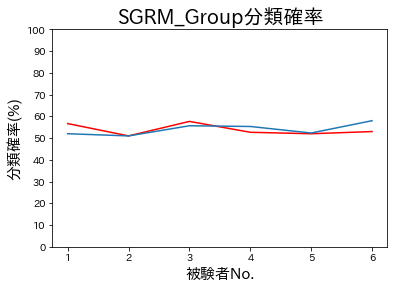

In [71]:
import matplotlib.pyplot as plt
import japanize_matplotlib
y = np.array([])
x = np.arange(1, 7, step=1)
y = np.append(p_average_250Hz[:,0],y)
y = np.append(p_average_125Hz[:,0],y)
y = y.reshape([2,6])
print(y)
plt.plot(x,y[1],"red")
plt.plot(x,y[0])
plt.title("SGRM_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.xticks(np.arange(1, 7, step=1))
plt.yticks(np.arange(0, 110, step=10))
plt.savefig("2a_SGRM_group_probability_K3.pdf")
plt.show()

In [72]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_aa_20.txt","feat_4a_1000Hz_20/feat_foot_aa_20.txt","feat_4a_1000Hz_Test/feat_test_right_aa.txt","feat_4a_1000Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30/feat_right_av_30.txt","feat_4a_1000Hz_30/feat_foot_av_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aw_30.txt","feat_4a_1000Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_av_20.txt","feat_4a_1000Hz_20/feat_foot_av_20.txt","feat_4a_1000Hz_Test/feat_test_right_av.txt","feat_4a_1000Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aa_30.txt","feat_4a_1000Hz_30/feat_foot_aa_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aw_30.txt","feat_4a_1000Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_aw_20.txt","feat_4a_1000Hz_20/feat_foot_aw_20.txt","feat_4a_1000Hz_Test/feat_test_right_aw.txt","feat_4a_1000Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aa_30.txt","feat_4a_1000Hz_30/feat_foot_aa_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_av_30.txt","feat_4a_1000Hz_30/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([3, 3])
print(probability_1)

1


/Users/kota/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


2
3
4
1
2
3
4
1
2
3
4
[[55. 84. 26.]
 [55. 74. 36.]
 [55. 76. 34.]]


In [73]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_aa_20.txt","feat_4a_1000Hz_20/feat_foot_aa_20.txt","feat_4a_1000Hz_Test/feat_test_right_aa.txt","feat_4a_1000Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_av_30.txt","feat_4a_1000Hz_30_2/feat_foot_av_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aw_30.txt","feat_4a_1000Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_av_20.txt","feat_4a_1000Hz_20/feat_foot_av_20.txt","feat_4a_1000Hz_Test/feat_test_right_av.txt","feat_4a_1000Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aa_30.txt","feat_4a_1000Hz_30_2/feat_foot_aa_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aw_30.txt","feat_4a_1000Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_aw_20.txt","feat_4a_1000Hz_20/feat_foot_aw_20.txt","feat_4a_1000Hz_Test/feat_test_right_aw.txt","feat_4a_1000Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aa_30.txt","feat_4a_1000Hz_30_2/feat_foot_aa_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_av_30.txt","feat_4a_1000Hz_30_2/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([3, 3])
print(probability_2)

1
2
3
4
1
2
3
4
1
2
3
4
[[57. 84. 30.]
 [54. 62. 46.]
 [52. 28. 76.]]


In [74]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_aa_20.txt","feat_4a_1000Hz_20/feat_foot_aa_20.txt","feat_4a_1000Hz_Test/feat_test_right_aa.txt","feat_4a_1000Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_av_30.txt","feat_4a_1000Hz_30_3/feat_foot_av_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aw_30.txt","feat_4a_1000Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_av_20.txt","feat_4a_1000Hz_20/feat_foot_av_20.txt","feat_4a_1000Hz_Test/feat_test_right_av.txt","feat_4a_1000Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aa_30.txt","feat_4a_1000Hz_30_3/feat_foot_aa_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aw_30.txt","feat_4a_1000Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_aw_20.txt","feat_4a_1000Hz_20/feat_foot_aw_20.txt","feat_4a_1000Hz_Test/feat_test_right_aw.txt","feat_4a_1000Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aa_30.txt","feat_4a_1000Hz_30_3/feat_foot_aa_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_av_30.txt","feat_4a_1000Hz_30_3/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([3, 3])
print(probability_3)

1
2
3
4
1
2
3
4
1
2
3
4
[[55. 72. 38.]
 [54. 20. 88.]
 [56. 82. 30.]]


In [75]:
p_average_1000Hz = (probability_1+probability_2+probability_3)/3
print(p_average_1000Hz)

[[55.66666667 80.         31.33333333]
 [54.33333333 52.         56.66666667]
 [54.33333333 62.         46.66666667]]


In [76]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_aa_20.txt","feat_4a_100Hz_20/feat_foot_aa_20.txt","feat_4a_100Hz_Test/feat_test_right_aa.txt","feat_4a_100Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30/feat_right_av_30.txt","feat_4a_100Hz_30/feat_foot_av_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_aw_30.txt","feat_4a_100Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_av_20.txt","feat_4a_100Hz_20/feat_foot_av_20.txt","feat_4a_100Hz_Test/feat_test_right_av.txt","feat_4a_100Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30/feat_right_aa_30.txt","feat_4a_100Hz_30/feat_foot_aa_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_aw_30.txt","feat_4a_100Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_aw_20.txt","feat_4a_100Hz_20/feat_foot_aw_20.txt","feat_4a_100Hz_Test/feat_test_right_aw.txt","feat_4a_100Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30/feat_right_aa_30.txt","feat_4a_100Hz_30/feat_foot_aa_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_av_30.txt","feat_4a_100Hz_30/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([3, 3])
print(probability_1)

1
2
3
4
1
2
3
4
1
2
3
4
[[ 50.   0. 100.]
 [ 49.  10.  88.]
 [ 50.   0. 100.]]


In [77]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_aa_20.txt","feat_4a_100Hz_20/feat_foot_aa_20.txt","feat_4a_100Hz_Test/feat_test_right_aa.txt","feat_4a_100Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_av_30.txt","feat_4a_100Hz_30_2/feat_foot_av_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aw_30.txt","feat_4a_100Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_av_20.txt","feat_4a_100Hz_20/feat_foot_av_20.txt","feat_4a_100Hz_Test/feat_test_right_av.txt","feat_4a_100Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aa_30.txt","feat_4a_100Hz_30_2/feat_foot_aa_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aw_30.txt","feat_4a_100Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_aw_20.txt","feat_4a_100Hz_20/feat_foot_aw_20.txt","feat_4a_100Hz_Test/feat_test_right_aw.txt","feat_4a_100Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aa_30.txt","feat_4a_100Hz_30_2/feat_foot_aa_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_av_30.txt","feat_4a_100Hz_30_2/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([3, 3])
print(probability_2)

1
2
3
4
1
2
3
4
1
2
3
4
[[ 54.  20.  88.]
 [ 50. 100.   0.]
 [ 55.  92.  18.]]


In [78]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_aa_20.txt","feat_4a_100Hz_20/feat_foot_aa_20.txt","feat_4a_100Hz_Test/feat_test_right_aa.txt","feat_4a_100Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_av_30.txt","feat_4a_100Hz_30_3/feat_foot_av_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aw_30.txt","feat_4a_100Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_av_20.txt","feat_4a_100Hz_20/feat_foot_av_20.txt","feat_4a_100Hz_Test/feat_test_right_av.txt","feat_4a_100Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aa_30.txt","feat_4a_100Hz_30_3/feat_foot_aa_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aw_30.txt","feat_4a_100Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_aw_20.txt","feat_4a_100Hz_20/feat_foot_aw_20.txt","feat_4a_100Hz_Test/feat_test_right_aw.txt","feat_4a_100Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aa_30.txt","feat_4a_100Hz_30_3/feat_foot_aa_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_av_30.txt","feat_4a_100Hz_30_3/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([3, 3])
print(probability_3)

1
2
3
4
1
2
3
4
1
2
3
4
[[ 50.   0. 100.]
 [ 48.   6.  90.]
 [ 54. 100.   8.]]


In [79]:
p_average_100Hz = (probability_1+probability_2+probability_3)/3
print(p_average_100Hz)

[[51.33333333  6.66666667 96.        ]
 [49.         38.66666667 59.33333333]
 [53.         64.         42.        ]]


In [80]:
a_20 = 0; a_30 = 0;
for i in range(3):
    a_20 = a_20 + p_average_1000Hz[i,0] 
    a_30 = a_30 + p_average_100Hz[i,0] 
    
a_20 = a_20/3
a_30 = a_30/3
print(a_20,a_30)

54.77777777777778 51.111111111111114


[[51.33333333 49.         53.        ]
 [55.66666667 54.33333333 54.33333333]]


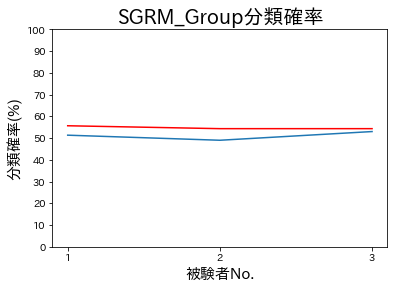

In [81]:
import matplotlib.pyplot as plt
import japanize_matplotlib
y = np.array([])
x = np.arange(1, 4, step=1)
y = np.append(p_average_1000Hz[:,0],y)
y = np.append(p_average_100Hz[:,0],y)
y = y.reshape([2,3])
print(y)
plt.plot(x,y[1],"red")
plt.plot(x,y[0])
plt.title("SGRM_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.xticks(np.arange(1, 4, step=1))
plt.yticks(np.arange(0, 110, step=10))
plt.savefig("4a_SGRM_group_probability_K3.pdf")
plt.show()

In [82]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A01T_10.txt","feat_2a_250Hz_10/feat_right_A01T_10.txt","feat_2a_250Hz_Test/feat_test_left_A01E.txt","feat_2a_250Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A02T_10.txt","feat_2a_250Hz_10/feat_right_A02T_10.txt","feat_2a_250Hz_Test/feat_test_left_A02E.txt","feat_2a_250Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A03T_10.txt","feat_2a_250Hz_10/feat_right_A03T_10.txt","feat_2a_250Hz_Test/feat_test_left_A03E.txt","feat_2a_250Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A07T_10.txt","feat_2a_250Hz_10/feat_right_A07T_10.txt","feat_2a_250Hz_Test/feat_test_left_A07E.txt","feat_2a_250Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A08T_10.txt","feat_2a_250Hz_10/feat_right_A08T_10.txt","feat_2a_250Hz_Test/feat_test_left_A08E.txt","feat_2a_250Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A09T_10.txt","feat_2a_250Hz_10/feat_right_A09T_10.txt","feat_2a_250Hz_Test/feat_test_left_A09E.txt","feat_2a_250Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A08T_30.txt","feat_2a_250Hz_30/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
print(probability_1)

1


/Users/kota/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
[[ 50.   2.  98.]
 [ 50.   0. 100.]
 [ 62.  48.  76.]
 [ 57.  46.  68.]
 [ 57.  18.  96.]
 [ 50.  92.   8.]]


In [83]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A01T_10.txt","feat_2a_250Hz_10/feat_right_A01T_10.txt","feat_2a_250Hz_Test/feat_test_left_A01E.txt","feat_2a_250Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A02T_10.txt","feat_2a_250Hz_10/feat_right_A02T_10.txt","feat_2a_250Hz_Test/feat_test_left_A02E.txt","feat_2a_250Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A03T_10.txt","feat_2a_250Hz_10/feat_right_A03T_10.txt","feat_2a_250Hz_Test/feat_test_left_A03E.txt","feat_2a_250Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A07T_10.txt","feat_2a_250Hz_10/feat_right_A07T_10.txt","feat_2a_250Hz_Test/feat_test_left_A07E.txt","feat_2a_250Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A08T_10.txt","feat_2a_250Hz_10/feat_right_A08T_10.txt","feat_2a_250Hz_Test/feat_test_left_A08E.txt","feat_2a_250Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A09T_10.txt","feat_2a_250Hz_10/feat_right_A09T_10.txt","feat_2a_250Hz_Test/feat_test_left_A09E.txt","feat_2a_250Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A08T_30.txt","feat_2a_250Hz_30_2/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
print(probability_2)

1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
[[ 50.   0. 100.]
 [ 51.  98.   4.]
 [ 52.  98.   6.]
 [ 52. 100.   4.]
 [ 51.   8.  94.]
 [ 54.  20.  88.]]


In [84]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A01T_10.txt","feat_2a_250Hz_10/feat_right_A01T_10.txt","feat_2a_250Hz_Test/feat_test_left_A01E.txt","feat_2a_250Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A02T_10.txt","feat_2a_250Hz_10/feat_right_A02T_10.txt","feat_2a_250Hz_Test/feat_test_left_A02E.txt","feat_2a_250Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A03T_10.txt","feat_2a_250Hz_10/feat_right_A03T_10.txt","feat_2a_250Hz_Test/feat_test_left_A03E.txt","feat_2a_250Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A07T_10.txt","feat_2a_250Hz_10/feat_right_A07T_10.txt","feat_2a_250Hz_Test/feat_test_left_A07E.txt","feat_2a_250Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A08T_10.txt","feat_2a_250Hz_10/feat_right_A08T_10.txt","feat_2a_250Hz_Test/feat_test_left_A08E.txt","feat_2a_250Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A09T_10.txt","feat_2a_250Hz_10/feat_right_A09T_10.txt","feat_2a_250Hz_Test/feat_test_left_A09E.txt","feat_2a_250Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A08T_30.txt","feat_2a_250Hz_30_3/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
print(probability_3)

1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
[[ 65.  72.  58.]
 [ 50.   0. 100.]
 [ 62.  66.  58.]
 [ 56.  74.  38.]
 [ 50. 100.   0.]
 [ 51.  96.   6.]]


In [85]:
p_average_250Hz = (probability_1+probability_2+probability_3)/3
print(p_average_250Hz)

[[55.         24.66666667 85.33333333]
 [50.33333333 32.66666667 68.        ]
 [58.66666667 70.66666667 46.66666667]
 [55.         73.33333333 36.66666667]
 [52.66666667 42.         63.33333333]
 [51.66666667 69.33333333 34.        ]]


In [86]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A01T_10.txt","feat_2a_125Hz_10/feat_right_A01T_10.txt","feat_2a_125Hz_Test/feat_test_left_A01E.txt","feat_2a_125Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A02T_10.txt","feat_2a_125Hz_10/feat_right_A02T_10.txt","feat_2a_125Hz_Test/feat_test_left_A02E.txt","feat_2a_125Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A03T_10.txt","feat_2a_125Hz_10/feat_right_A03T_10.txt","feat_2a_125Hz_Test/feat_test_left_A03E.txt","feat_2a_125Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A07T_10.txt","feat_2a_125Hz_10/feat_right_A07T_10.txt","feat_2a_125Hz_Test/feat_test_left_A07E.txt","feat_2a_125Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A08T_10.txt","feat_2a_125Hz_10/feat_right_A08T_10.txt","feat_2a_125Hz_Test/feat_test_left_A08E.txt","feat_2a_125Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A09T_10.txt","feat_2a_125Hz_10/feat_right_A09T_10.txt","feat_2a_125Hz_Test/feat_test_left_A09E.txt","feat_2a_125Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A08T_30.txt","feat_2a_125Hz_30/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
print(probability_1)

1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
[[ 53.  54.  52.]
 [ 50.   0. 100.]
 [ 59.  40.  78.]
 [ 50.   0. 100.]
 [ 50. 100.   0.]
 [ 64.  66.  62.]]


In [87]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A01T_10.txt","feat_2a_125Hz_10/feat_right_A01T_10.txt","feat_2a_125Hz_Test/feat_test_left_A01E.txt","feat_2a_125Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A02T_10.txt","feat_2a_125Hz_10/feat_right_A02T_10.txt","feat_2a_125Hz_Test/feat_test_left_A02E.txt","feat_2a_125Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A03T_10.txt","feat_2a_125Hz_10/feat_right_A03T_10.txt","feat_2a_125Hz_Test/feat_test_left_A03E.txt","feat_2a_125Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A07T_10.txt","feat_2a_125Hz_10/feat_right_A07T_10.txt","feat_2a_125Hz_Test/feat_test_left_A07E.txt","feat_2a_125Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A08T_10.txt","feat_2a_125Hz_10/feat_right_A08T_10.txt","feat_2a_125Hz_Test/feat_test_left_A08E.txt","feat_2a_125Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A09T_10.txt","feat_2a_125Hz_10/feat_right_A09T_10.txt","feat_2a_125Hz_Test/feat_test_left_A09E.txt","feat_2a_125Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A06T_30.txt","feat_2a_125Hz_30_2/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
print(probability_2)

1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
[[ 50.   0. 100.]
 [ 51. 100.   2.]
 [ 50. 100.   0.]
 [ 59.  60.  58.]
 [ 50. 100.   0.]
 [ 61.  32.  90.]]


In [88]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A01T_10.txt","feat_2a_125Hz_10/feat_right_A01T_10.txt","feat_2a_125Hz_Test/feat_test_left_A01E.txt","feat_2a_125Hz_Test/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A02T_10.txt","feat_2a_125Hz_10/feat_right_A02T_10.txt","feat_2a_125Hz_Test/feat_test_left_A02E.txt","feat_2a_125Hz_Test/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A03T_10.txt","feat_2a_125Hz_10/feat_right_A03T_10.txt","feat_2a_125Hz_Test/feat_test_left_A03E.txt","feat_2a_125Hz_Test/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A07T_10.txt","feat_2a_125Hz_10/feat_right_A07T_10.txt","feat_2a_125Hz_Test/feat_test_left_A07E.txt","feat_2a_125Hz_Test/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A08T_10.txt","feat_2a_125Hz_10/feat_right_A08T_10.txt","feat_2a_125Hz_Test/feat_test_left_A08E.txt","feat_2a_125Hz_Test/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A09T_10.txt","feat_2a_125Hz_10/feat_right_A09T_10.txt","feat_2a_125Hz_Test/feat_test_left_A09E.txt","feat_2a_125Hz_Test/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A08T_30.txt","feat_2a_125Hz_30_3/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
print(probability_3)

1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
[[ 51.   4.  98.]
 [ 50.   0. 100.]
 [ 52.  88.  16.]
 [ 56.  12. 100.]
 [ 52.  52.  52.]
 [ 64.  68.  60.]]


In [89]:
p_average_125Hz = (probability_1+probability_2+probability_3)/3
print(p_average_125Hz)

[[51.33333333 19.33333333 83.33333333]
 [50.33333333 33.33333333 67.33333333]
 [53.66666667 76.         31.33333333]
 [55.         24.         86.        ]
 [50.66666667 84.         17.33333333]
 [63.         55.33333333 70.66666667]]


In [90]:
a_20 = 0; a_30 = 0;
for i in range(6):
    a_20 = a_20 + p_average_250Hz[i,0] 
    a_30 = a_30 + p_average_125Hz[i,0] 
    
a_20 = a_20/6
a_30 = a_30/6
print(a_20,a_30)

53.88888888888889 54.0


[[51.33333333 50.33333333 53.66666667 55.         50.66666667 63.        ]
 [55.         50.33333333 58.66666667 55.         52.66666667 51.66666667]]


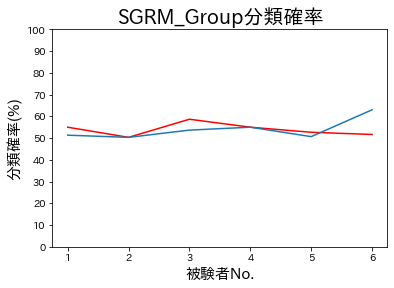

In [91]:
import matplotlib.pyplot as plt
import japanize_matplotlib
y = np.array([])
x = np.arange(1, 7, step=1)
y = np.append(p_average_250Hz[:,0],y)
y = np.append(p_average_125Hz[:,0],y)
y = y.reshape([2,6])
print(y)
plt.plot(x,y[1],"red")
plt.plot(x,y[0])
plt.title("SGRM_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.xticks(np.arange(1, 7, step=1))
plt.yticks(np.arange(0, 110, step=10))
plt.savefig("2a_SGRM_group_probability_K3_down.pdf")
plt.show()

In [92]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_aa_10.txt","feat_4a_1000Hz_10/feat_foot_aa_10.txt","feat_4a_1000Hz_Test/feat_test_right_aa.txt","feat_4a_1000Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30/feat_right_av_30.txt","feat_4a_1000Hz_30/feat_foot_av_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aw_30.txt","feat_4a_1000Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_av_10.txt","feat_4a_1000Hz_10/feat_foot_av_10.txt","feat_4a_1000Hz_Test/feat_test_right_av.txt","feat_4a_1000Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aa_30.txt","feat_4a_1000Hz_30/feat_foot_aa_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aw_30.txt","feat_4a_1000Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_aw_10.txt","feat_4a_1000Hz_10/feat_foot_aw_10.txt","feat_4a_1000Hz_Test/feat_test_right_aw.txt","feat_4a_1000Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aa_30.txt","feat_4a_1000Hz_30/feat_foot_aa_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_av_30.txt","feat_4a_1000Hz_30/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([3, 3])
print(probability_1)

1


/Users/kota/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


2
3
4
1
2
3
4
1
2
3
4
[[53. 88. 18.]
 [57. 30. 84.]
 [55. 50. 60.]]


In [93]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_aa_10.txt","feat_4a_1000Hz_10/feat_foot_aa_10.txt","feat_4a_1000Hz_Test/feat_test_right_aa.txt","feat_4a_1000Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_av_30.txt","feat_4a_1000Hz_30_2/feat_foot_av_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aw_30.txt","feat_4a_1000Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_av_10.txt","feat_4a_1000Hz_10/feat_foot_av_10.txt","feat_4a_1000Hz_Test/feat_test_right_av.txt","feat_4a_1000Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aa_30.txt","feat_4a_1000Hz_30_2/feat_foot_aa_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aw_30.txt","feat_4a_1000Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_aw_10.txt","feat_4a_1000Hz_10/feat_foot_aw_10.txt","feat_4a_1000Hz_Test/feat_test_right_aw.txt","feat_4a_1000Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aa_30.txt","feat_4a_1000Hz_30_2/feat_foot_aa_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_av_30.txt","feat_4a_1000Hz_30_2/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([3, 3])
print(probability_2)

1
2
3
4
1
2
3
4
1
2
3
4
[[54. 90. 18.]
 [53. 26. 80.]
 [54. 16. 92.]]


In [94]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_aa_10.txt","feat_4a_1000Hz_10/feat_foot_aa_10.txt","feat_4a_1000Hz_Test/feat_test_right_aa.txt","feat_4a_1000Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_av_30.txt","feat_4a_1000Hz_30_3/feat_foot_av_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aw_30.txt","feat_4a_1000Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_av_10.txt","feat_4a_1000Hz_10/feat_foot_av_10.txt","feat_4a_1000Hz_Test/feat_test_right_av.txt","feat_4a_1000Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aa_30.txt","feat_4a_1000Hz_30_3/feat_foot_aa_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aw_30.txt","feat_4a_1000Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_aw_10.txt","feat_4a_1000Hz_10/feat_foot_aw_10.txt","feat_4a_1000Hz_Test/feat_test_right_aw.txt","feat_4a_1000Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aa_30.txt","feat_4a_1000Hz_30_3/feat_foot_aa_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_av_30.txt","feat_4a_1000Hz_30_3/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([3, 3])
print(probability_3)

1
2
3
4
1
2
3
4
1
2
3
4
[[ 54.  34.  74.]
 [ 50.   0. 100.]
 [ 53.  22.  84.]]


In [95]:
p_average_1000Hz = (probability_1+probability_2+probability_3)/3
print(p_average_1000Hz)

[[53.66666667 70.66666667 36.66666667]
 [53.33333333 18.66666667 88.        ]
 [54.         29.33333333 78.66666667]]


In [96]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_aa_10.txt","feat_4a_100Hz_10/feat_foot_aa_10.txt","feat_4a_100Hz_Test/feat_test_right_aa.txt","feat_4a_100Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30/feat_right_av_30.txt","feat_4a_100Hz_30/feat_foot_av_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_aw_30.txt","feat_4a_100Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_av_10.txt","feat_4a_100Hz_10/feat_foot_av_10.txt","feat_4a_100Hz_Test/feat_test_right_av.txt","feat_4a_100Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30/feat_right_aa_30.txt","feat_4a_100Hz_30/feat_foot_aa_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_aw_30.txt","feat_4a_100Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_aw_10.txt","feat_4a_100Hz_10/feat_foot_aw_10.txt","feat_4a_100Hz_Test/feat_test_right_aw.txt","feat_4a_100Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30/feat_right_aa_30.txt","feat_4a_100Hz_30/feat_foot_aa_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_av_30.txt","feat_4a_100Hz_30/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([3, 3])
print(probability_1)

1
2
3
4
1
2
3
4
1
2
3
4
[[ 50.   0. 100.]
 [ 54.  72.  36.]
 [ 61.  58.  64.]]


In [97]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_aa_10.txt","feat_4a_100Hz_10/feat_foot_aa_10.txt","feat_4a_100Hz_Test/feat_test_right_aa.txt","feat_4a_100Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_av_30.txt","feat_4a_100Hz_30_2/feat_foot_av_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aw_30.txt","feat_4a_100Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_av_10.txt","feat_4a_100Hz_10/feat_foot_av_10.txt","feat_4a_100Hz_Test/feat_test_right_av.txt","feat_4a_100Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aa_30.txt","feat_4a_100Hz_30_2/feat_foot_aa_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aw_30.txt","feat_4a_100Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_aw_10.txt","feat_4a_100Hz_10/feat_foot_aw_10.txt","feat_4a_100Hz_Test/feat_test_right_aw.txt","feat_4a_100Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aa_30.txt","feat_4a_100Hz_30_2/feat_foot_aa_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_av_30.txt","feat_4a_100Hz_30_2/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([3, 3])
print(probability_2)


1
2
3
4
1
2
3
4
1
2
3
4
[[ 53.  42.  64.]
 [ 50. 100.   0.]
 [ 50. 100.   0.]]


In [98]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_aa_10.txt","feat_4a_100Hz_10/feat_foot_aa_10.txt","feat_4a_100Hz_Test/feat_test_right_aa.txt","feat_4a_100Hz_Test/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_av_30.txt","feat_4a_100Hz_30_3/feat_foot_av_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aw_30.txt","feat_4a_100Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_av_10.txt","feat_4a_100Hz_10/feat_foot_av_10.txt","feat_4a_100Hz_Test/feat_test_right_av.txt","feat_4a_100Hz_Test/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aa_30.txt","feat_4a_100Hz_30_3/feat_foot_aa_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aw_30.txt","feat_4a_100Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_aw_10.txt","feat_4a_100Hz_10/feat_foot_aw_10.txt","feat_4a_100Hz_Test/feat_test_right_aw.txt","feat_4a_100Hz_Test/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aa_30.txt","feat_4a_100Hz_30_3/feat_foot_aa_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_av_30.txt","feat_4a_100Hz_30_3/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([3, 3])
print(probability_3)

1
2
3
4
1
2
3
4
1
2
3
4
[[ 50.   0. 100.]
 [ 48.   6.  90.]
 [ 54. 100.   8.]]


In [99]:
p_average_100Hz = (probability_1+probability_2+probability_3)/3
print(p_average_100Hz)

[[51.         14.         88.        ]
 [50.66666667 59.33333333 42.        ]
 [55.         86.         24.        ]]


In [100]:
a_20 = 0; a_30 = 0;
for i in range(3):
    a_20 = a_20 + p_average_1000Hz[i,0] 
    a_30 = a_30 + p_average_100Hz[i,0] 
    
a_20 = a_20/3
a_30 = a_30/3
print(a_20,a_30)

53.666666666666664 52.22222222222222


[[51.         50.66666667 55.        ]
 [53.66666667 53.33333333 54.        ]]


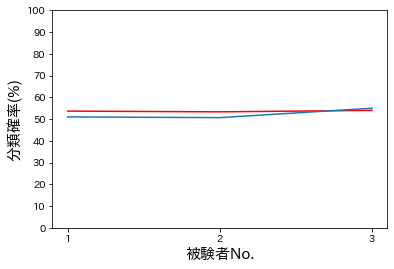

In [101]:
import matplotlib.pyplot as plt
import japanize_matplotlib
y = np.array([])
x = np.arange(1, 4, step=1)
y = np.append(p_average_1000Hz[:,0],y)
y = np.append(p_average_100Hz[:,0],y)
y = y.reshape([2,3])
print(y)
plt.plot(x,y[1],"red")
plt.plot(x,y[0])
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.xticks(np.arange(1, 4, step=1))
plt.yticks(np.arange(0, 110, step=10))
plt.savefig("4a_SGRM_group_probability_K3_10.pdf")
plt.show()

In [103]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_1 = probability.reshape([3, 3])
print(probability_1)

1


/Users/kota/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


2
3
4
1
2
3
4
1
2
3
4
[[54. 12. 96.]
 [54. 42. 66.]
 [54. 10. 98.]]


In [104]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([3, 3])
print(probability_2)

1
2
3
4
1
2
3
4
1
2
3
4
[[ 50.   0. 100.]
 [ 55.  50.  60.]
 [ 50.   0. 100.]]


In [105]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_3 = probability.reshape([3, 3])
print(probability_3)

1
2
3
4
1
2
3
4
1
2
3
4
[[ 50. 100.   0.]
 [ 56.  50.  62.]
 [ 55.  22.  88.]]


In [106]:
p_average_250Hz = (probability_1+probability_2+probability_3)/3
print(p_average_250Hz)

[[51.33333333 37.33333333 65.33333333]
 [55.         47.33333333 62.66666667]
 [53.         10.66666667 95.33333333]]


In [107]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([3, 3])
print(probability_1)

1
2
3
4
1
2
3
4
1
2
3
4
[[60. 96. 24.]
 [55. 64. 46.]
 [59. 36. 82.]]


In [108]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_2 = probability.reshape([3, 3])
print(probability_2)

1
2
3
4
1
2
3
4
1
2
3
4
[[63. 90. 36.]
 [55. 44. 66.]
 [56. 24. 88.]]


In [110]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_3 = probability.reshape([3, 3])
print(probability_3)
        

1
2
3
4
1
2
3
4
1
2
3
4
[[53. 86. 20.]
 [52. 98.  6.]
 [54. 14. 94.]]


In [111]:
p_average_125Hz = (probability_1+probability_2+probability_3)/3
print(p_average_125Hz)

[[58.66666667 90.66666667 26.66666667]
 [54.         68.66666667 39.33333333]
 [56.33333333 24.66666667 88.        ]]


In [112]:
a_20 = 0; a_30 = 0;
for i in range(3):
    a_20 = a_20 + p_average_250Hz[i,0] 
    a_30 = a_30 + p_average_125Hz[i,0] 
    
a_20 = a_20/3
a_30 = a_30/3
print(a_20,a_30)

53.111111111111114 56.333333333333336


In [113]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_1 = probability.reshape([3, 3])
print(probability_1)

1
2
3
4
1
2
3
4
1
2
3
4
[[ 53.  98.   8.]
 [ 50. 100.   0.]
 [ 50. 100.   0.]]


In [114]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_2 = probability.reshape([3, 3])
print(probability_2)

1
2
3
4
1
2
3
4
1
2
3
4
[[58. 64. 52.]
 [52. 28. 76.]
 [47. 80. 14.]]


In [115]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_3 = probability.reshape([3, 3])
print(probability_3)

1
2
3
4
1
2
3
4
1
2
3
4
[[ 50. 100.   0.]
 [ 50.   0. 100.]
 [ 54.  76.  32.]]


In [116]:
p_average_250Hz = (probability_1+probability_2+probability_3)/3
print(p_average_250Hz)

[[53.66666667 87.33333333 20.        ]
 [50.66666667 42.66666667 58.66666667]
 [50.33333333 85.33333333 15.33333333]]


In [117]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_1 = probability.reshape([3, 3])
print(probability_1)

1
2
3
4
1
2
3
4
1
2
3
4
[[ 53.  82.  24.]
 [ 50. 100.   0.]
 [ 54.   8. 100.]]


In [118]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_2 = probability.reshape([3, 3])
print(probability_2)

1
2
3
4
1
2
3
4
1
2
3
4
[[ 53.  98.   8.]
 [ 50. 100.   0.]
 [ 50. 100.   0.]]


In [119]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_3 = probability.reshape([3, 3])
print(probability_3)
        

1
2
3
4
1
2
3
4
1
2
3
4
[[ 52.   6.  98.]
 [ 62.  52.  72.]
 [ 50. 100.   0.]]


In [120]:
p_average_125Hz = (probability_1+probability_2+probability_3)/3
print(p_average_125Hz)

[[52.66666667 62.         43.33333333]
 [54.         84.         24.        ]
 [51.33333333 69.33333333 33.33333333]]


In [121]:
a_20 = 0; a_30 = 0;
for i in range(2):
    a_20 = a_20 + p_average_250Hz[i,0] 
    a_30 = a_30 + p_average_125Hz[i,0] 
    
a_20 = a_20/2
a_30 = a_30/2
print(a_20,a_30)

52.166666666666664 53.33333333333333
